## MCMC attempt

# (1) First attempt and naïve approch

We start by treating all parameters as independent and ignoring degeneracies. This is expected to fail: age, distance and extinction are intrinsically degenerate. For example, a very young isochrone placed at a large distance and assigned strong extinction can mimic the observed CMD. With only broadband photometry we do not have enough information to break these degeneracies, so many mathematically valid but physically different solutions exist. A simple, unconstrained MCMC will therefore likely produce unrealistic or ambiguous results.

But we need to start somewhere and ajust.

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import emcee
import logging
import math
emcee_logger = logging.getLogger("emcee")
emcee_logger.setLevel(logging.DEBUG)


path_data_ohp = "../../process_data/result/final_cluster_catalog_OHP.csv"
path_data_lyon = "../../process_data/result/final_cluster_catalog_lyon.csv"

#read data
data_ohp = Table.read(path_data_ohp, format="csv")
data_lyon = Table.read(path_data_lyon, format="csv")

g = data_ohp['mag_g_cal']
r = data_ohp['mag_r_cal']
i = data_ohp['mag_i_cal']

# In case we want to use Lyon telescope data we just need to uncomment the following part:

# g = data_lyon['mag_g_cal']
# r = data_lyon['mag_r_cal']
# i = data_lyon['mag_i_cal']

# Construct CMD (g'-r', g')
color_gr_obs = g - r
g_obs = g

# Construct CMD (r'-i', r')
color_ri_obs = r - i
r_obs = r

# Construct CMD (g'-i', g')
color_gi_obs = g - i
i_obs = i

# Security
mask_finite =( np.isfinite(color_gr_obs) & np.isfinite(g_obs) 
& np.isfinite(color_ri_obs) & np.isfinite(r_obs) 
& np.isfinite(color_gi_obs) & np.isfinite(i_obs))

color_gr_obs = color_gr_obs[mask_finite]
g_obs = g_obs[mask_finite]
color_ri_obs = color_ri_obs[mask_finite]
r_obs = r_obs[mask_finite]
color_gi_obs = color_gi_obs[mask_finite]
i_obs = i_obs[mask_finite]


# g_err = data["g_err"]
# r_err = data["r_err"]
# i_err = data["i_err"]

# as we don't have clear uncertainty we'll that this values independent as the truth
SIG_COLOR = 0.05  
SIG_MAG = 0.05    


#Initial Guess close to what we find in our previous analysis
log_age_myr = math.log(1e8,10)
initial_log_age = log_age_myr   # ~ 100 Myr
initial_mu = 11.0       # ~ 1.6 kpc
initial_Ag = 1.0        # No specific reason
initial_Ar = 0.8        # Just using decreasing extinction Ag >= Ar >= Ai
initial_Ai = 0.6
initial = np.array([initial_log_age, initial_mu, initial_Ag, initial_Ar, initial_Ai])





def load_parsec_isochrones(filename):
    tab = Table.read(filename, format="ascii")

    needed = ["col3", "col29", "col30", "col31"]
    for col in needed:
        if col not in tab.colnames:
            raise ValueError(
                f"Colonne '{col}' absente du fichier PARSEC. "
                f"Colonnes disponibles : {tab.colnames}"
            )

    age_log = np.array(tab["col3"])   # log10(age/yr)
    Mg = np.array(tab["col29"])
    Mr = np.array(tab["col30"])
    Mi = np.array(tab["col31"])

    age_years = 10**age_log
    return age_years, Mg, Mr, Mi


isochrones_file = "../../isochrones.dat"
age_years_all, Mg_all, Mr_all, Mi_all = load_parsec_isochrones(isochrones_file)
unique_ages = np.unique(age_years_all)

#Move data in a more useful repertories
iso_by_age = {}
for age in unique_ages:
    mask = (age_years_all == age)
    iso_by_age[age] = {
        "Mg": Mg_all[mask],
        "Mr": Mr_all[mask],
        "Mi": Mi_all[mask],
    }

ages_grid = np.array(sorted(iso_by_age.keys()))








In [111]:
# Model 
# might evolve during our process
def shift_isochrone(iso, mu, Ag, Ar, Ai):
    """
    Applique module de distance + extinction aux magnitudes absolues.
    mu  = module de distance
    A*  = extinction dans chaque filtre
    """
    Mg = iso["Mg"]
    Mr = iso["Mr"]
    Mi = iso["Mi"]

    g = Mg + mu + Ag
    r = Mr + mu + Ar
    i = Mi + mu + Ai
    return g, r, i


def iso_cmd_gr(iso, mu, Ag, Ar, Ai):
    """Renvoie l'isochrone dans le plan (g-r, g)."""
    g, r, i = shift_isochrone(iso, mu, Ag, Ar, Ai)
    col_gr = g - r
    return col_gr, g

In [112]:

def log_prior_1(theta):
    """
    theta = [log10(age/yr), mu, Ag, Ar, Ai]
    Priors uniformes "raisonnables".

    The idea of our MCMC was to try to ajust parameters using simply priors (Uniform) on our parameters
    """
    log_age, mu, Ag, Ar, Ai = theta

    # Prior section might be a subject to discussion (spoiler : yes)
    # Age between isochrones limits we downloaded
    if not (6.0 < log_age < 10.1):
        return -np.inf

    # mu (distance moduli) between reasonable limits
    if not (8.0 < mu < 15.0):
        return -np.inf

    # Extinctions only restricted to positive and not too high values
    if not (0.0 <= Ag <= 5.0):
        return -np.inf
    if not (0.0 <= Ar <= 5.0):
        return -np.inf
    if not (0.0 <= Ai <= 5.0):
        return -np.inf

    # Constrains physics for : Ag >= Ar >= Ai (decreasing extinction towards IR)
    if not (Ag >= Ar >= Ai):
        return -np.inf

    return 0.0


def log_likelihood_1(theta, iso_by_age, ages_grid, color_gr_obs, g_obs):
    log_age, mu, Ag, Ar, Ai = theta

    # log_age -> age (years)
    age = 10**log_age

    #search for the closest isochrone age in the grid
    idx = np.argmin(np.abs(ages_grid - age))
    age_iso = ages_grid[idx]
    iso = iso_by_age[age_iso]

    # Isochrone for the CMD (g-r, g)
    iso_col_gr, iso_g = iso_cmd_gr(iso, mu, Ag, Ar, Ai)

    dcol = color_gr_obs[:, None] - iso_col_gr[None, :]
    dmag = g_obs[:, None]        - iso_g[None, :]

    # χ² law based on the minimum distance between each star
    # for both color and magnitude
    chi2_matrix = (dcol**2 / SIG_COLOR**2) + (dmag**2 / SIG_MAG**2)
    chi2_per_star = np.min(chi2_matrix, axis=1)

    chi2_tot = np.sum(chi2_per_star)
    logL = -0.5 * chi2_tot
    return logL


def log_posterior_1(theta, iso_by_age, ages_grid, color_gr_obs, g_obs):
    lp = log_prior_1(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_1(theta, iso_by_age, ages_grid, color_gr_obs, g_obs)
    return lp + ll




In [113]:

ndim = 5  # [log_age, mu, Ag, Ar, Ai]
nwalkers = 64
pos0_1 = initial + 1e-2*np.random.randn(nwalkers, ndim) # Small spread to avoid walkers being in the exact same position

sampler_1 = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_posterior_1,
    args=(iso_by_age, ages_grid, color_gr_obs, g_obs),
)


nsteps = 1000  
sampler_1.run_mcmc(pos0_1, nsteps, progress=True)

burnin = int(nsteps * (20 / 100)) # On discard 20% of the chain as burn-in
# To ensure that the walkers have converged and are sampling from the target distribution not from initial positions
samples_1 = sampler_1.get_chain(discard=burnin, flat=True)



100%|██████████| 1000/1000 [02:23<00:00,  6.96it/s]


In [114]:
log_age_mcmc, mu_mcmc, Ag_mcmc, Ar_mcmc, Ai_mcmc = np.median(samples_1, axis=0)

best_age = 10**log_age_mcmc

print("----- Résults MCMC (median) -----")
print(f"log10(age/yr) = {log_age_mcmc:.3f}")
print(f"Age (Myr)     = {10**log_age_mcmc/1e6:.2f}")
print(f"mu            = {mu_mcmc:.3f} mag")
print(f"distance (pc) = {10**((mu_mcmc + 5)/5):.1f}")
print(f"Ag, Ar, Ai    = {Ag_mcmc:.3f}, {Ar_mcmc:.3f}, {Ai_mcmc:.3f}")

----- Résults MCMC (median) -----
log10(age/yr) = 6.740
Age (Myr)     = 5.50
mu            = 9.436 mag
distance (pc) = 771.1
Ag, Ar, Ai    = 3.505, 3.041, 1.666


Just looking as this result, we cannot say anything anything more
Let's just check many others informations to process and futher enhance our MCMC:

-Evolution of the walkers -> to see how they converge
-Superposition of the

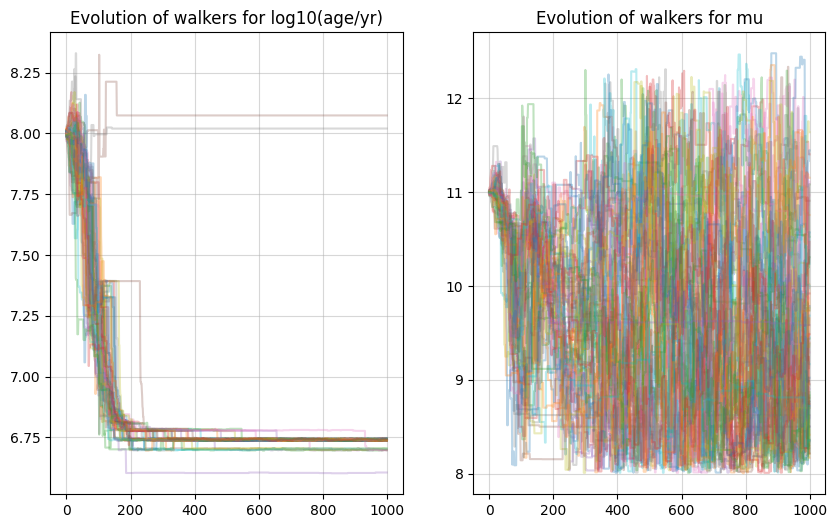

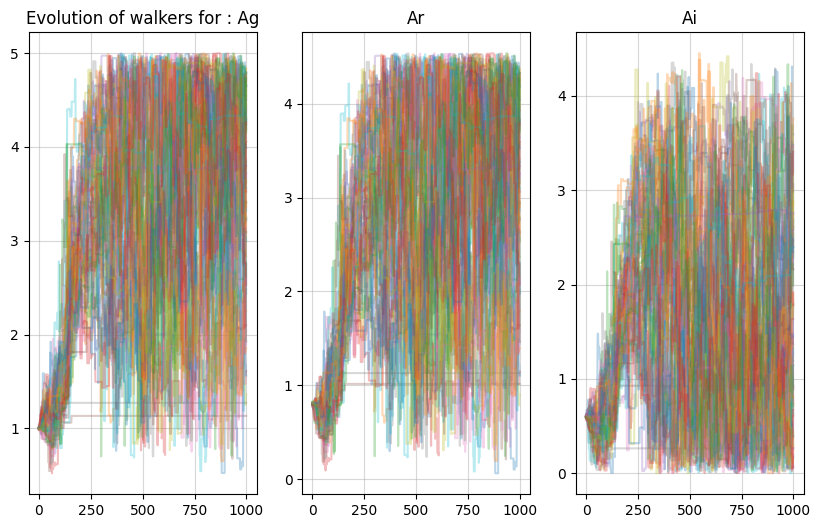

In [115]:

log_ages_samples_1 = sampler_1.get_chain()[:,:,0]  # log_age is the first parameter
mu_samples_1 = sampler_1.get_chain()[:,:,1]  # log_age is the first parameter
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(log_ages_samples_1, alpha=0.3)
plt.title("Evolution of walkers for log10(age/yr)")
plt.grid(True, alpha=0.5)


plt.subplot(1,2,2)
plt.plot(mu_samples_1, alpha=0.3)
plt.title("Evolution of walkers for mu")
plt.grid(True, alpha=0.5)
plt.show()


Ag_samples_1 , Ar_samples_1, Ai_samples_1 = sampler_1.get_chain()[:,:,2], sampler_1.get_chain()[:,:,3], sampler_1.get_chain()[:,:,4]

plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
plt.plot(Ag_samples_1, alpha=0.3)
plt.title("Evolution of walkers for : Ag")
plt.grid(True, alpha=0.5)

plt.subplot(1,3,2)
plt.plot(Ar_samples_1, alpha=0.3)
plt.title("Ar")
plt.grid(True, alpha=0.5)

plt.subplot(1,3,3)
plt.plot(Ai_samples_1, alpha=0.3)
plt.title("Ai")
plt.grid(True, alpha=0.5)
plt.show()

### Analysis of the first MCMC attempt (free parameters, single CMD)

As expected, the results show very strong degeneracies, especially between the extinction coefficients \(A_g, A_r, A_i\). Since these three parameters play a similar role (a vertical and horizontal shift of the isochrone), the walkers do not converge toward any well-defined solution. Instead, they simply explore a broad region of parameter space, and the resulting "mean" values are only statistical averages of this exploration rather than meaningful best-fit estimates.

For the distance modulus, the behaviour of the walkers shows almost no real convergence. 

For age, the behaviour is slightly different. We see partial convergence toward several possible solutions, each corresponding to a different combination of age, distance, and extinction. This is exactly the signature of the intrinsic degeneracy of isochrone fitting (other than non converging solution)


This confirms that additional information is required to break these degeneracies. We must either restrict or inform the parameter space (e.g. with astrophysical priors) or incorporate more observational constraints. In the next steps, we will attempt to reduce the degeneracy by simplifying the extinction model and by experimenting with more realistic parameter bounds.

Before doing so, we can still overlay the MCMC best-fit isochrone on the CMD to check whether the solution is at least visually consistent with the data.


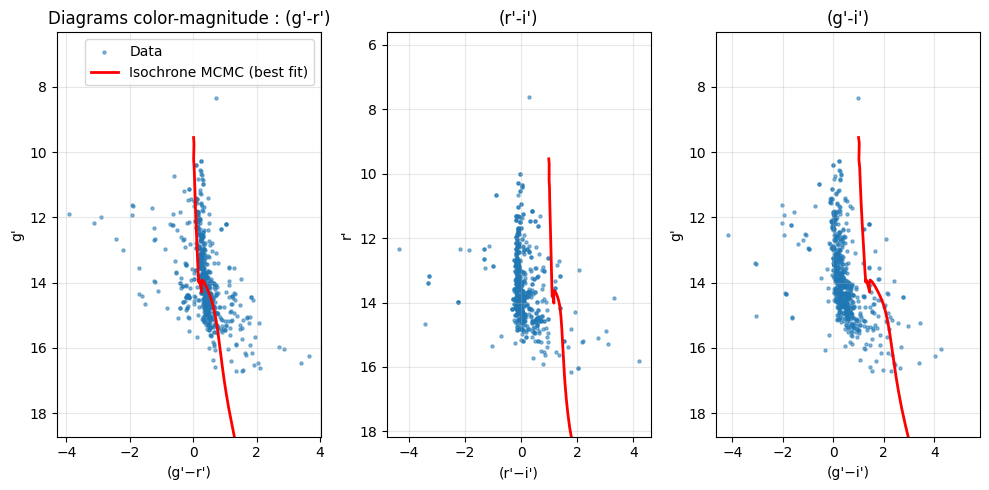

In [116]:
best_age = 10**log_age_mcmc
idx = np.argmin(np.abs(ages_grid - best_age))
iso = iso_by_age[ages_grid[idx]]

g_iso, r_iso, i_iso = shift_isochrone(iso, mu_mcmc, Ag_mcmc, Ar_mcmc, Ai_mcmc)
color_gr_iso = g_iso - r_iso
color_ri_iso = r_iso - i_iso
color_gi_iso = g_iso - i_iso

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.scatter(g - r, g, s=5, alpha=0.5, label="Data")
plt.plot(color_gr_iso, g_iso, 'r-', lw=2, label="Isochrone MCMC (best fit)")
plt.gca().invert_yaxis()
plt.xlabel("(g'−r')")
plt.ylabel("g'")
plt.title("Diagrams color-magnitude : (g'-r')")
plt.ylim(max(g) + 2 , min(g) - 2)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,3,2)
plt.scatter(r - i, r, s=5, alpha=0.5)
plt.plot(color_ri_iso, r_iso, 'r-', lw=2)
plt.gca().invert_yaxis()
plt.xlabel("(r'−i')")
plt.ylabel("r'")
plt.title("(r'-i')")
plt.ylim(max(r) + 2 , min(r) - 2)
plt.grid(True, alpha=0.3)

plt.subplot(1,3,3)
plt.scatter(g - i, g, s=5, alpha=0.5)
plt.plot(color_gi_iso, g_iso, 'r-', lw=2)
plt.gca().invert_yaxis()
plt.xlabel("(g'−i')")
plt.ylabel("g'")
plt.title("(g'-i')")
plt.ylim(max(g) + 2 , min(g) - 2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



The behaviour differs strongly between the diagrams, overall, only the (g′-r′,g′) CMD provides a consistent match with the MCMC best-fit isochrone as it was only fit on it and show pretty bad result for the other


## (1.5) Second attempt

In this second attempt, we keep the same modelling setup as before but we include the additional CMDs (r'-i',r') and (g'-i',g').  
The goal is not to change the fitting strategy, but simply to test whenever adding these colour–magnitude diagrams helps the walkers converge toward a clearer solution or reveals additional structure in the parameter space.

We do not expect a major improvement, since this extension does not resolve the main source of degeneracy: the extinction coefficients $A_g$, $A_r$, and $A_i$ remain strongly correlated with each other and therefore cannot be constrained independently by broadband photometry alone.



In [117]:
def log_likelihood_2(theta, iso_by_age, ages_grid,
                   color_gr_obs, g_obs,
                   color_ri_obs, r_obs):
    log_age, mu, Ag, Ar, Ai = theta

    # log_age -> age (years)
    age = 10**log_age

    #search for the closest isochrone age in the grid
    idx = np.argmin(np.abs(ages_grid - age))
    age_iso = ages_grid[idx]
    iso = iso_by_age[age_iso]

    # CMD 1 : (g-r, g)
    iso_col_gr, iso_g = iso_cmd_gr(iso, mu, Ag, Ar, Ai)

    dcol = color_gr_obs[:, None] - iso_col_gr[None, :]
    dmag = g_obs[:, None]        - iso_g[None, :]

    # χ² law based on the minimum distance between each star
    # for both color and magnitude
    chi2_cmd1 = (dcol**2 / SIG_COLOR**2) + (dmag**2 / SIG_MAG**2)
    chi2_min_cmd1 = np.min(chi2_cmd1, axis=1)



    # CMD 2 : (r-i, r) 
    iso_col_ri = r_iso - i_iso

    dcol2 = color_ri_obs[:, None] - iso_col_ri[None, :]
    dmag2 = r_obs[:, None]        - r_iso[None, :]

    chi2_cmd2 = (dcol2**2 / SIG_COLOR**2) + (dmag2**2 / SIG_MAG**2)
    chi2_min_cmd2 = np.min(chi2_cmd2, axis=1)

    # CMD 3 : (g-i, g)
    iso_col_gi = g_iso - i_iso
    dcol3 = color_gi_obs[:, None] - iso_col_gi[None, :]
    dmag3 = g_obs[:, None]        - g_iso[None, :]
    chi2_cmd3 = (dcol3**2 / SIG_COLOR**2) + (dmag3**2 / SIG_MAG**2)
    chi2_min_cmd3 = np.min(chi2_cmd3, axis=1)



    # χ_tot²
    chi2_total = np.sum(chi2_min_cmd1 + chi2_min_cmd2 + chi2_min_cmd3)
    return -0.5 * chi2_total

def log_posterior_2(theta, iso_by_age, ages_grid,
                  color_gr_obs, g_obs,
                  color_ri_obs, r_obs):
    lp = log_prior_1(theta) # we can use the same prior as before
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_2(theta, iso_by_age, ages_grid,
                        color_gr_obs, g_obs,
                        color_ri_obs, r_obs)
    return lp + ll


In [118]:
ndim = 5  # [log_age, mu, Ag, Ar, Ai]
nwalkers = 32



pos0_2 = initial + 1e-3 * np.random.randn(nwalkers, ndim)

sampler_2 = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_posterior_2,
    args=(iso_by_age, ages_grid,
          color_gr_obs, g_obs,
          color_ri_obs, r_obs),
)


nsteps = 1000  
sampler_2.run_mcmc(pos0_2, nsteps, progress=True)


burnin = int(nsteps * (20 / 100))
samples_2 = sampler_2.get_chain(discard=burnin, flat=True)


100%|██████████| 1000/1000 [03:34<00:00,  4.67it/s]


In [119]:
log_age_mcmc, mu_mcmc, Ag_mcmc, Ar_mcmc, Ai_mcmc = np.median(samples_2, axis=0)

print("----- Résultats MCMC (médianes) -----")
print(f"log10(age/yr) = {log_age_mcmc:.3f}")
print(f"Age (Myr)     = {10**log_age_mcmc/1e6:.2f}")
print(f"mu            = {mu_mcmc:.3f} mag")
print(f"distance (pc) = {10**((mu_mcmc + 5)/5):.1f}")
print(f"Ag, Ar, Ai    = {Ag_mcmc:.3f}, {Ar_mcmc:.3f}, {Ai_mcmc:.3f}")


----- Résultats MCMC (médianes) -----
log10(age/yr) = 7.882
Age (Myr)     = 76.18
mu            = 10.598 mag
distance (pc) = 1316.9
Ag, Ar, Ai    = 0.801, 0.401, 0.131


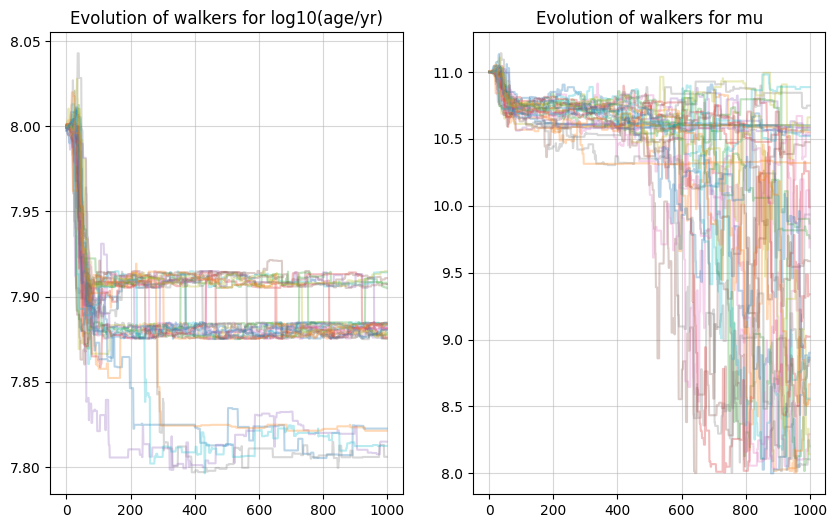

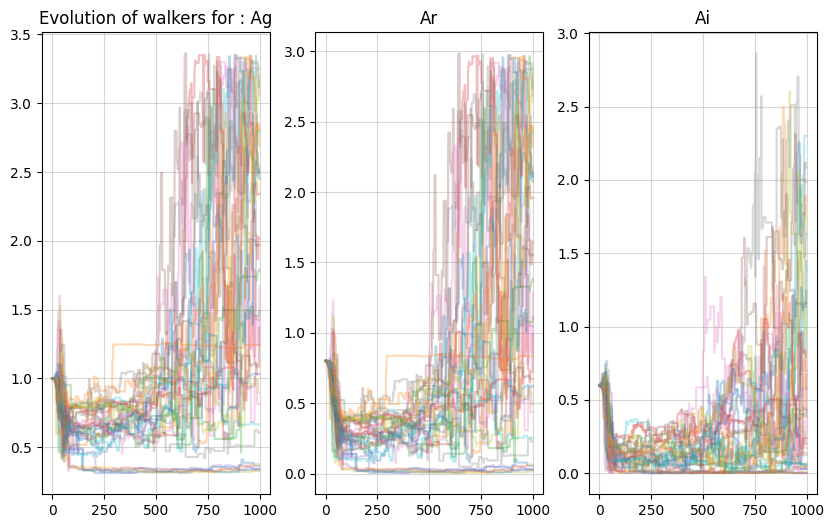

In [120]:
log_ages_samples_2 = sampler_2.get_chain()[:,:,0]  # log_age is the first parameter
mu_samples_2 = sampler_2.get_chain()[:,:,1]  # log_age is the first parameter
plt.figure(figsize=(10, 6))
plt.subplot(1,2,1)
plt.plot(log_ages_samples_2, alpha=0.3)
plt.title("Evolution of walkers for log10(age/yr)")
plt.grid(True, alpha=0.5)


plt.subplot(1,2,2)
plt.plot(mu_samples_2, alpha=0.3)
plt.title("Evolution of walkers for mu")
plt.grid(True, alpha=0.5)
plt.show()


Ag_samples_2 , Ar_samples_2, Ai_samples_2 = sampler_2.get_chain()[:,:,2], sampler_2.get_chain()[:,:,3], sampler_2.get_chain()[:,:,4]

plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
plt.plot(Ag_samples_2, alpha=0.3)
plt.title("Evolution of walkers for : Ag")
plt.grid(True, alpha=0.5)

plt.subplot(1,3,2)
plt.plot(Ar_samples_2, alpha=0.3)
plt.title("Ar")
plt.grid(True, alpha=0.5)

plt.subplot(1,3,3)
plt.plot(Ai_samples_2, alpha=0.3)
plt.title("Ai")
plt.grid(True, alpha=0.5)
plt.show()

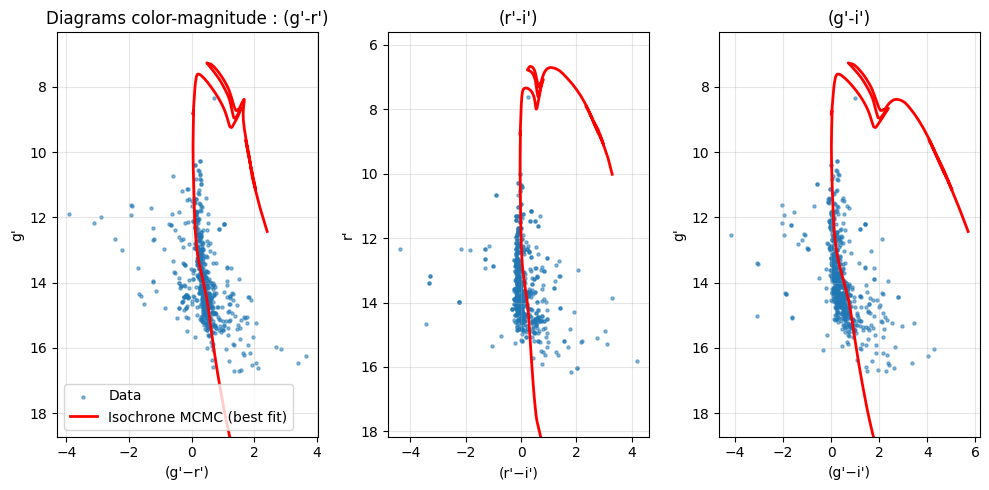

In [121]:
best_age = 10**log_age_mcmc
idx = np.argmin(np.abs(ages_grid - best_age))
iso = iso_by_age[ages_grid[idx]]

g_iso, r_iso, i_iso = shift_isochrone(iso, mu_mcmc, Ag_mcmc, Ar_mcmc, Ai_mcmc)
color_gr_iso = g_iso - r_iso
color_ri_iso = r_iso - i_iso
color_gi_iso = g_iso - i_iso

plt.figure(figsize=(10,5))
plt.subplot(1,3,1)
plt.scatter(g - r, g, s=5, alpha=0.5, label="Data")
plt.plot(color_gr_iso, g_iso, 'r-', lw=2, label="Isochrone MCMC (best fit)")
plt.gca().invert_yaxis()
plt.xlabel("(g'−r')")
plt.ylabel("g'")
plt.title("Diagrams color-magnitude : (g'-r')")
plt.ylim(max(g) + 2 , min(g) - 2)
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1,3,2)
plt.scatter(r - i, r, s=5, alpha=0.5)
plt.plot(color_ri_iso, r_iso, 'r-', lw=2)
plt.gca().invert_yaxis()
plt.xlabel("(r'−i')")
plt.ylabel("r'")
plt.title("(r'-i')")
plt.ylim(max(r) + 2 , min(r) - 2)
plt.grid(True, alpha=0.3)

plt.subplot(1,3,3)
plt.scatter(g - i, g, s=5, alpha=0.5)
plt.plot(color_gi_iso, g_iso, 'r-', lw=2)
plt.gca().invert_yaxis()
plt.xlabel("(g'−i')")
plt.ylabel("g'")
plt.title("(g'-i')")
plt.ylim(max(g) + 2 , min(g) - 2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Analysis of the second MCMC attempt (multiple CMDs)

Including the additional CMDs (r'-i',r') and (g'-i',g') does not improve the behaviour of the MCMC.  
The extinction parameters $A_g$, $A_r$, and $A_i$ remain strongly degenerate, and the walkers are unable to converge toward a single or even multiples solution. Instead, they just wander across a wide region of parameter space, which confirms that these three quantities cannot be constrained independently from broadband photometry alone.

For age we observe a similar pattern as in the first attempt: the chain quickly collapses toward a young and highly extinguished solution, while a smaller fraction of walkers stays around a more realistic configuration near $\log(\mathrm{age/yr}) \approx 7.8$. A young and highly reddened model can mimic an older and less extinguished that what we can see


For distance modulus we also observe a similar pattern without a clearer convergence toward a solution, at least not clearly

This indicates that several combinations of age, distance, and extinction still produce comparable fits to the data.


Overall, this second attempt confirms that we cannot recover a stable best-fit solution while treating $A_g$, $A_r$, and $A_i$ as independent parameters.


---

# (3) Reducing the extinction degeneracy

The previous attempts confirmed that treating the three extinction coefficients 
$(A_g, A_r, A_i)$ as independent parameters leads to a fully degenerate model:  
broadband photometry does not contain enough information to constrain them separately.

To make progress, we now adopt a more physically motivated approach.  
Instead of fitting $A_g$, $A_r$, and $A_i$ independently, we replace them with a 
single parameter — the standard reddening value E(B-V) and compute the 
corresponding extinctions using fixed coefficients from the Pan-STARRS extinction law.

This reduces the dimensionality of the problem and removes one of the main sources 
of degeneracy. The goal of this third attempt is therefore to test whether the MCMC 
converges toward a more stable and physically meaningful solution once the extinction 
model is simplified.

In our case, if the MCMC still fails to converge toward a clearer (even multiples solutions), even after reducing the extinction degeneracy then we may have to abandon this approach .



In [122]:
# Coefficients de Schlafly & Finkbeiner (2011) pour SDSS
k_g = 3.172
k_r = 2.271
k_i = 1.698

def extinctions_from_ebv(ebv):
    Ag = k_g * ebv
    Ar = k_r * ebv
    Ai = k_i * ebv
    return Ag, Ar, Ai

In [123]:


def log_prior_3(theta):
    log_age, mu, ebv = theta

    # prior borne âge
    if not (6.0 < log_age < 10.1):
        return -np.inf

    # prior distance amas
    if not (8.0 < mu < 15.0):
        return -np.inf

    # prior extinction
    if not (0.2 < ebv < 1.5):
        return -np.inf

    lp = 0.0
    # prior simple et léger
    lp += -0.5 * ((log_age - 8.1)/0.2)**2
    # prior simple et léger
    lp += -0.5 * ((ebv - 0.6)/0.1)**2

    return lp





def log_likelihood_3(theta, iso_by_age, ages_grid,
                   color_gr_obs, g_obs,
                   color_ri_obs, r_obs):

    log_age, mu, ebv = theta

    # extinction
    Ag, Ar, Ai = extinctions_from_ebv(ebv)

    age = 10**log_age

    idx = np.argmin(np.abs(ages_grid - age))
    iso = iso_by_age[ages_grid[idx]]

    g_iso, r_iso, i_iso = shift_isochrone(iso, mu, Ag, Ar, Ai)

    # CMD1 : (g-r, g)
    iso_gr = g_iso - r_iso
    dcol1 = color_gr_obs[:,None] - iso_gr[None,:]
    dmag1 = g_obs[:,None]        - g_iso[None,:]
    chi2_1 = (dcol1**2 / SIG_COLOR**2) + (dmag1**2 / SIG_MAG**2)
    chi2_min1 = np.min(chi2_1, axis=1)

    
    
    iso_ri = r_iso - i_iso
    dcol2 = color_ri_obs[:,None] - iso_ri[None,:]
    dmag2 = r_obs[:,None]        - r_iso[None,:]
    chi2_2 = (dcol2**2 / SIG_COLOR**2) + (dmag2**2 / SIG_MAG**2)
    chi2_min2 = np.min(chi2_2, axis=1)

    iso_gi = g_iso - i_iso
    dcol3 = color_gi_obs[:,None] - iso_gi[None,:]
    dmag3 = g_obs[:,None]        - g_iso[None,:]
    chi2_3 = (dcol3**2 / SIG_COLOR**2) + (dmag3**2 / SIG_MAG**2)
    chi2_min3 = np.min(chi2_3, axis=1)

    chi2 = np.sum(chi2_min1 + chi2_min2 + chi2_min3)

    return -0.5 * chi2


def log_posterior_3(theta, iso_by_age, ages_grid,
                  color_gr_obs, g_obs,
                  color_ri_obs, r_obs):
    lp = log_prior_3(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_3(theta, iso_by_age, ages_grid,
                        color_gr_obs, g_obs,
                        color_ri_obs, r_obs)
    return lp + ll



In [124]:
ndim = 3   # log_age, mu, E(B-V)
nwalkers = 64

age_log_myr = math.log(1e8,10)

initial = np.array([age_log_myr, 11, 0.5])  # initial guess : log_age, mu, E(B-V)
pos0_3 = initial + 1e-3 * np.random.randn(nwalkers, ndim)

sampler_3 = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_3,
    args=(iso_by_age, ages_grid,
          color_gr_obs, g_obs,
          color_ri_obs, r_obs)
)
n_steps = 1000
sampler_3.run_mcmc(pos0_3, n_steps, progress=True)


100%|██████████| 1000/1000 [07:33<00:00,  2.21it/s]


State([[ 6.81118456 11.32335394  0.53055483]
 [ 6.81185806 11.32056302  0.53075928]
 [ 6.80956245 11.32265506  0.52963681]
 [ 6.81353331 11.32705053  0.53268484]
 [ 6.80535069 11.31958194  0.53255209]
 [ 6.80842014 11.32347521  0.53258652]
 [ 6.81242531 11.31886846  0.53034647]
 [ 6.80619153 11.32193523  0.53076095]
 [ 6.80549608 11.31703875  0.53477791]
 [ 6.80695054 11.3208221   0.53202418]
 [ 6.81178559 11.31992932  0.53127268]
 [ 6.80794874 11.31898203  0.53140814]
 [ 6.80533994 11.31824927  0.53329117]
 [ 6.81426337 11.31597716  0.53508563]
 [ 6.81477007 11.32288581  0.53109636]
 [ 6.80986553 11.32237851  0.53093296]
 [ 6.80661493 11.31633887  0.53487813]
 [ 6.81446737 11.31739983  0.53116674]
 [ 6.77536532 11.39543666  0.54155417]
 [ 6.80975986 11.3170175   0.53465666]
 [ 6.81374176 11.3223724   0.53248036]
 [ 6.8066872  11.31821267  0.53320909]
 [ 6.81447935 11.32592201  0.53221723]
 [ 6.80905286 11.32198421  0.53281504]
 [ 6.80790908 11.32476017  0.53273589]
 [ 6.78176065 11.40

In [125]:
n_bursting = int(n_steps * (20 / 100))

samples_3 = sampler_3.get_chain(discard=n_bursting, flat=True)

log_age_mcmc, mu_mcmc, ebv_mcmc = np.median(samples_3, axis=0)

#incertitudes mcmc 
#just using it as information as there no physical meaning to them

log_age_low, mu_low, ebv_low = np.percentile(samples_3, 16, axis=0)
log_age_high, mu_high, ebv_high = np.percentile(samples_3, 84, axis=0)

dlog_age = 0.5 * (log_age_high - log_age_low)
dmu      = 0.5 * (mu_high - mu_low)
debv     = 0.5 * (ebv_high - ebv_low)



print("----- Résultats MCMC -----")
print(f"log10(age/yr) = {log_age_mcmc:.3f} ± {dlog_age:.3f}")
print(f"Âge (Myr)     = {(10**log_age_mcmc)/1e6:.2f} ± {(10**(log_age_mcmc + dlog_age))/1e6 - (10**(log_age_mcmc - dlog_age))/1e6:.2f}")
print(f"mu            = {mu_mcmc:.3f} ± {dmu:.3f}")
print(f"distance (pc) = {10**((mu_mcmc+5)/5):.1f} ± {((10**((mu_mcmc + dmu +5)/5)) - (10**((mu_mcmc - dmu +5)/5))):.1f}")
print(f"E(B-V)        = {ebv_mcmc:.3f} ± {debv:.3f}")





----- Résultats MCMC -----
log10(age/yr) = 6.810 ± 0.004
Âge (Myr)     = 6.46 ± 0.11
mu            = 11.320 ± 0.004
distance (pc) = 1836.4 ± 6.6
E(B-V)        = 0.533 ± 0.002


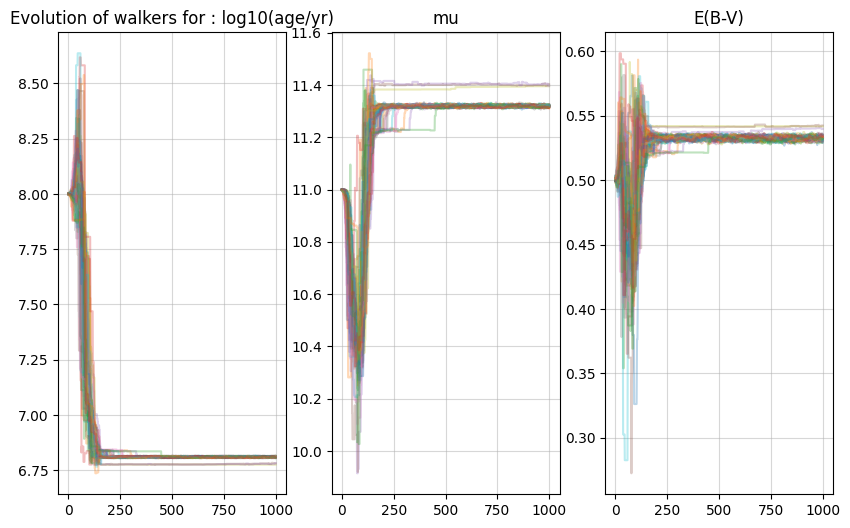

In [126]:
log_ages_samples_3 = sampler_3.get_chain()[:,:,0]  # log_age is the first parameter
mu_samples_3 = sampler_3.get_chain()[:,:,1]  # log_age is the first parameter
ebv_samples_3 = sampler_3.get_chain()[:,:,2]
plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
plt.plot(log_ages_samples_3, alpha=0.3)
plt.title("Evolution of walkers for : log10(age/yr)")
plt.grid(True, alpha=0.5)


plt.subplot(1,3,2)
plt.plot(mu_samples_3, alpha=0.3)
plt.title("mu")
plt.grid(True, alpha=0.5)


plt.subplot(1,3,3)
plt.plot(ebv_samples_3, alpha=0.3)
plt.title("E(B-V)")
plt.grid(True, alpha=0.5)
plt.show()




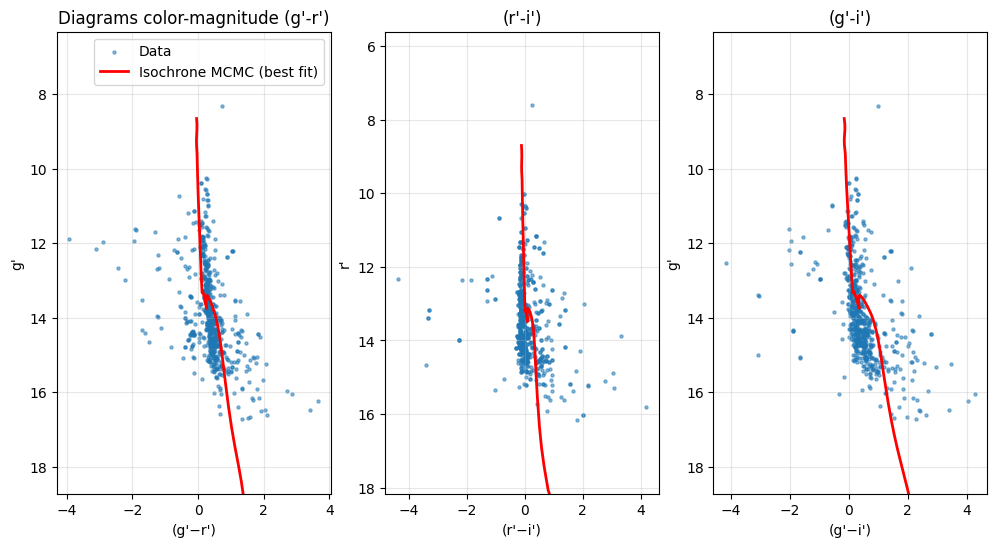

In [127]:
# isochrone correspondante
best_age = 10**log_age_mcmc
idx = np.argmin(np.abs(ages_grid - best_age))
iso = iso_by_age[ages_grid[idx]]

g_iso, r_iso, i_iso = shift_isochrone(iso, mu_mcmc, Ag_mcmc, Ar_mcmc, Ai_mcmc)
color_gr_iso = g_iso - r_iso
color_ri_iso = r_iso - i_iso
color_gi_iso = g_iso - i_iso

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.scatter(g - r, g, s=5, alpha=0.5, label="Data")
plt.plot(color_gr_iso, g_iso, 'r-', lw=2, label="Isochrone MCMC (best fit)")
plt.gca().invert_yaxis()
plt.xlabel("(g'−r')")
plt.ylabel("g'")
plt.title("Diagrams color-magnitude (g'-r')")
plt.ylim(max(g) + 2 , min(g) - 2)
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(1,3,2)
plt.scatter(r - i, r, s=5, alpha=0.5)
plt.plot(color_ri_iso, r_iso, 'r-', lw=2)
plt.gca().invert_yaxis()
plt.xlabel("(r'−i')")
plt.ylabel("r'")
plt.title("(r'-i')")
plt.ylim(max(r) + 2 , min(r) - 2)
plt.grid(True, alpha=0.3)
plt.subplot(1,3,3)  
plt.scatter(g-i, g, s=5, alpha=0.5)
plt.plot(color_gi_iso, g_iso, 'r-', lw=2)
plt.gca().invert_yaxis()
plt.xlabel("(g'−i')")
plt.ylabel("g'")
plt.title("(g'-i')")
plt.ylim(max(g) + 2 , min(g) - 2)
plt.grid(True, alpha=0.3)
plt.show()


Even after simplifying the extinction model to a single E(B−V), the MCMC still prefers 
relatively young solutions. This is due to the intrinsic age–reddening–distance 
degeneracy combined with the fact that our likelihood is dominated by the numerous 
stars on the lower main sequence, which are almost insensitive to age. Small 
systematic offsets in colour calibration and in the extinction law are then 
compensated by choosing a younger and more reddened isochrone, even though the 
resulting turn-off morphology is not fully satisfactory.

# (4) A final attemps adding more constraints prior for age 

In [128]:

def log_prior_4(theta):
    log_age, mu, ebv = theta

    # prior borne âge
    if not (7.6 < log_age < 10.1):
        return -np.inf

    # prior distance amas
    if not (8 < mu < 12.5):
        return -np.inf

    # prior extinction
    if not (0.4 < ebv < 1.5):
        return -np.inf

    lp = 0.0
    # prior simple et léger
    lp += -0.5 * ((log_age - 8.1)/0.2)**2
    # prior simple et léger
    lp += -0.5 * ((ebv - 0.6)/0.1)**2

    return lp





def log_likelihood_4(theta, iso_by_age, ages_grid,
                   color_gr_obs, g_obs,
                   color_ri_obs, r_obs):

    log_age, mu, ebv = theta

    # extinction
    Ag, Ar, Ai = extinctions_from_ebv(ebv)

    # age = 10**log_age
    age = 10**log_age

    # sélection isochrone la plus proche
    idx = np.argmin(np.abs(ages_grid - age))
    iso = iso_by_age[ages_grid[idx]]

    # décalage iso
    g_iso, r_iso, i_iso = shift_isochrone(iso, mu, Ag, Ar, Ai)

    # CMD1 : (g-r, g)
    iso_gr = g_iso - r_iso
    dcol1 = color_gr_obs[:,None] - iso_gr[None,:]
    dmag1 = g_obs[:,None]        - g_iso[None,:]
    chi2_1 = (dcol1**2 / SIG_COLOR**2) + (dmag1**2 / SIG_MAG**2)
    chi2_min1 = np.min(chi2_1, axis=1)

    # As the data with i tends to bias the result toward young age we will not use them for now
    

    # # CMD2 : (r-i, r)
    # iso_ri = r_iso - i_iso
    # dcol2 = color_ri_obs[:,None] - iso_ri[None,:]
    # dmag2 = r_obs[:,None]        - r_iso[None,:]
    # chi2_2 = (dcol2**2 / SIG_COLOR**2) + (dmag2**2 / SIG_MAG**2)
    # chi2_min2 = np.min(chi2_2, axis=1)

    # # CMD3 : (g-i, g)
    # iso_gi = g_iso - i_iso
    # dcol3 = color_gi_obs[:,None] - iso_gi[None,:]
    # dmag3 = g_obs[:,None]        - g_iso[None,:]
    # chi2_3 = (dcol3**2 / SIG_COLOR**2) + (dmag3**2 / SIG_MAG**2)
    # chi2_min3 = np.min(chi2_3, axis=1)

    chi2 = np.sum(chi2_min1)

    return -0.5 * chi2


def log_posterior_4(theta, iso_by_age, ages_grid,
                  color_gr_obs, g_obs,
                  color_ri_obs, r_obs):
    lp = log_prior_4(theta)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood_4(theta, iso_by_age, ages_grid,
                        color_gr_obs, g_obs,
                        color_ri_obs, r_obs)
    return lp + ll



In [129]:
ndim = 3   # log_age, mu, E(B-V)
nwalkers = 64


pos0_4 = initial + 1e-2 * np.random.randn(nwalkers, ndim)

sampler_4 = emcee.EnsembleSampler(
    nwalkers, ndim, log_posterior_4,
    args=(iso_by_age, ages_grid,
          color_gr_obs, g_obs,
          color_ri_obs, r_obs)
)
n_steps = 1000
sampler_4.run_mcmc(pos0_4, n_steps, progress=True)


100%|██████████| 1000/1000 [04:04<00:00,  4.09it/s]


State([[ 7.70967777 10.03575446  0.41698837]
 [ 7.73168342 10.10080571  0.45627776]
 [ 7.71812507 10.10614261  0.45618731]
 [ 7.88429971 11.20985484  0.66518141]
 [ 7.81253048 10.08341224  0.46170822]
 [ 7.71119848 10.10628317  0.45457111]
 [ 7.71770396 10.09615029  0.45839737]
 [ 7.71650521 10.09590308  0.4566267 ]
 [ 7.72464582 10.10440955  0.45437489]
 [ 7.71900106 10.09988539  0.45524323]
 [ 7.71535747 10.10820033  0.45465043]
 [ 7.71734113 10.10121058  0.45494235]
 [ 7.72271586 10.09913745  0.45777908]
 [ 7.8056023  10.10497729  0.4573301 ]
 [ 7.71788006 10.11008535  0.45219639]
 [ 7.71524506 10.09108634  0.45545896]
 [ 7.80987984 10.09609211  0.4582292 ]
 [ 7.72406474 10.10308356  0.45484787]
 [ 7.7220429  10.10918192  0.45431071]
 [ 7.7223875  10.10658437  0.45346831]
 [ 7.73045158 10.08640685  0.45866861]
 [ 7.72064699 10.0985587   0.45831115]
 [ 7.72304227 10.0967879   0.45484593]
 [ 7.72329625 10.1129504   0.45496891]
 [ 7.80681356 10.10528029  0.45753728]
 [ 7.71746769 10.12

In [130]:
n_bursting = int(n_steps * (20 / 100))

samples_4 = sampler_4.get_chain(discard=n_bursting, flat=True)

log_age_mcmc, mu_mcmc, ebv_mcmc = np.median(samples_4, axis=0)

#incertitudes mcmc
# 16th and 84th percentiles
log_age_low, mu_low, ebv_low = np.percentile(samples_4, 16, axis=0)
log_age_high, mu_high, ebv_high = np.percentile(samples_4, 84, axis=0)

# Uncertainties (symmetric)
dlog_age = 0.5 * (log_age_high - log_age_low)
dmu      = 0.5 * (mu_high - mu_low)
debv     = 0.5 * (ebv_high - ebv_low)



print("----- Résultats MCMC -----")
print(f"log10(age/yr) = {log_age_mcmc:.3f} ± {dlog_age:.3f}")
print(f"Âge (Myr)     = {(10**log_age_mcmc)/1e6:.2f} ± {(10**(log_age_mcmc + dlog_age))/1e6 - (10**(log_age_mcmc - dlog_age))/1e6:.2f}")
print(f"mu            = {mu_mcmc:.3f} ± {dmu:.3f}")
print(f"distance (pc) = {10**((mu_mcmc+5)/5):.1f} ± {((10**((mu_mcmc + dmu +5)/5)) - (10**((mu_mcmc - dmu +5)/5))):.1f}")
print(f"E(B-V)        = {ebv_mcmc:.3f} ± {debv:.3f}")





----- Résultats MCMC -----
log10(age/yr) = 7.721 ± 0.045
Âge (Myr)     = 52.61 ± 11.03
mu            = 10.103 ± 0.010
distance (pc) = 1048.5 ± 9.3
E(B-V)        = 0.455 ± 0.003


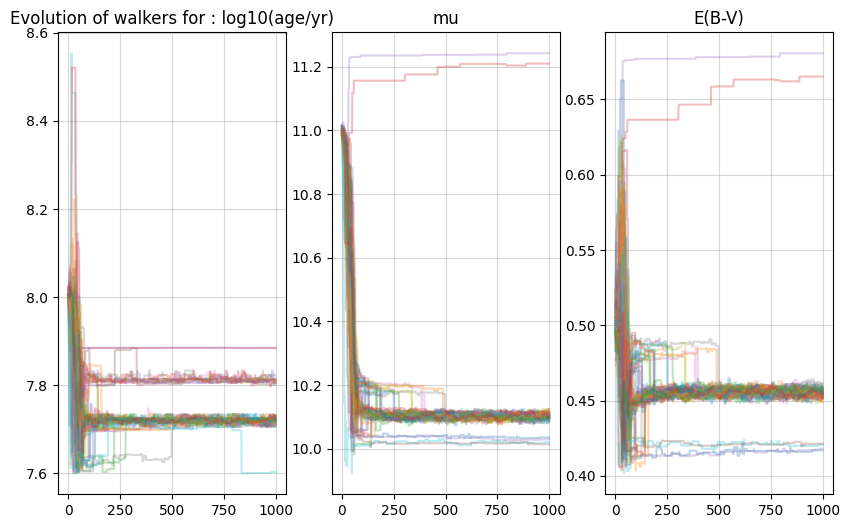

In [131]:
log_ages_samples_4 = sampler_4.get_chain()[:,:,0]  # log_age is the first parameter
mu_samples_4 = sampler_4.get_chain()[:,:,1]  # log_age is the first parameter
ebv_samples_4 = sampler_4.get_chain()[:,:,2]
plt.figure(figsize=(10, 6))
plt.subplot(1,3,1)
plt.plot(log_ages_samples_4, alpha=0.3)
plt.title("Evolution of walkers for : log10(age/yr)")
plt.grid(True, alpha=0.5)


plt.subplot(1,3,2)
plt.plot(mu_samples_4, alpha=0.3)
plt.title("mu")
plt.grid(True, alpha=0.5)


plt.subplot(1,3,3)
plt.plot(ebv_samples_4, alpha=0.3)
plt.title("E(B-V)")
plt.grid(True, alpha=0.5)
plt.show()




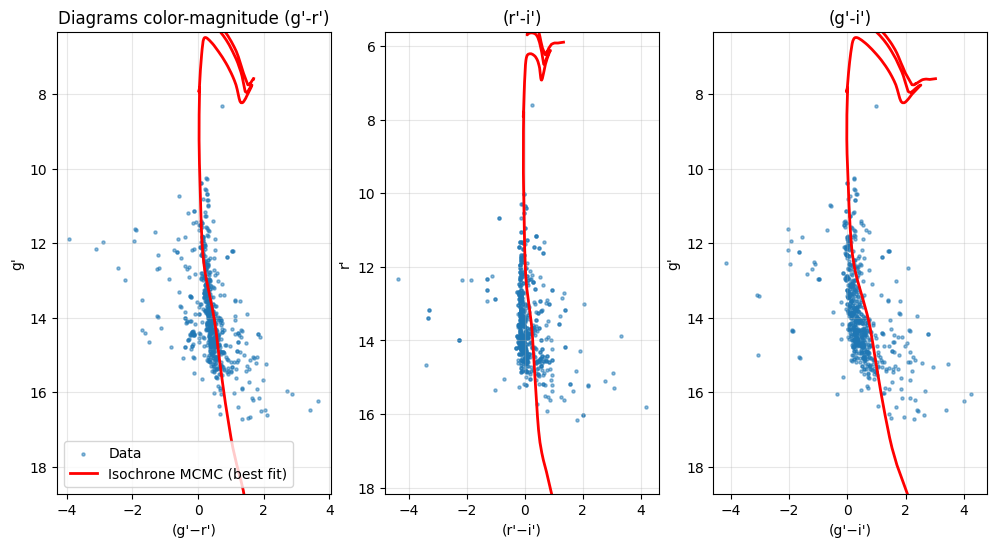

In [132]:
# isochrone correspondante
best_age = 10**log_age_mcmc
idx = np.argmin(np.abs(ages_grid - best_age))
iso = iso_by_age[ages_grid[idx]]

g_iso, r_iso, i_iso = shift_isochrone(iso, mu_mcmc, Ag_mcmc, Ar_mcmc, Ai_mcmc)
color_gr_iso = g_iso - r_iso
color_ri_iso = r_iso - i_iso
color_gi_iso = g_iso - i_iso

plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.scatter(g - r, g, s=5, alpha=0.5, label="Data")
plt.plot(color_gr_iso, g_iso, 'r-', lw=2, label="Isochrone MCMC (best fit)")
plt.gca().invert_yaxis()
plt.xlabel("(g'−r')")
plt.ylabel("g'")
plt.title("Diagrams color-magnitude (g'-r')")
plt.ylim(max(g) + 2 , min(g) - 2)
plt.legend()
plt.grid(True, alpha=0.3)
plt.subplot(1,3,2)
plt.scatter(r - i, r, s=5, alpha=0.5)
plt.plot(color_ri_iso, r_iso, 'r-', lw=2)
plt.gca().invert_yaxis()
plt.xlabel("(r'−i')")
plt.ylabel("r'")
plt.title("(r'-i')")
plt.ylim(max(r) + 2 , min(r) - 2)
plt.grid(True, alpha=0.3)
plt.subplot(1,3,3)  
plt.scatter(g-i, g, s=5, alpha=0.5)
plt.plot(color_gi_iso, g_iso, 'r-', lw=2)
plt.gca().invert_yaxis()
plt.xlabel("(g'−i')")
plt.ylabel("g'")
plt.title("(g'-i')")
plt.ylim(max(g) + 2 , min(g) - 2)
plt.grid(True, alpha=0.3)
plt.show()


Because of time limitations, we did not pursue a full optimisation of the MCMC 
framework. Several improvements would likely reduce the tendency of the sampler to 
converge toward the artificially young branch.

A first step would be to reweight the contribution of each star in the likelihood so that bright stars near the 
main-sequence turn-off the only ones truly sensitive to age carry more weight 
than the large population of faint stars on the lower main sequence. In parallel, 
stronger or more informative priors on age, distance modulus and reddening could 
help. Finally, a more sophisticated treatment of the photometric calibration, including colour-term 
corrections or instrument-specific extinction coefficients, would reduce the 
systematic offsets that currently bias the inference. 

Implementing these would probably yield a more stable and astrophysically meaningful posterior, 
but falls outside the scope of the present work.
